In [1]:
import pandas as pd
import glob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import matplotlib

In [2]:
csv_files = glob.glob("./CleanedCommentsV2/*.csv")
dfs = []

In [3]:
for csv_file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file, sep=';')
    # Append the DataFrame to the list
    dfs.append(df)

In [4]:
dataset = pd.concat(dfs, ignore_index=True)

In [5]:
dataset.head()

,id,name,text,time,likes,reply,CleanedText,ProcessText,ActualLabel
0,UCkM3xW7cOcRekISepJFCNew,@davidbreier84,"I think for the foreseeable future (or say, a ...",2023-05-07T04:22:57Z,267,NaN,"I think for the foreseeable future or say, a f...",think foreseeable future say year least not af...,Negative
1,UC9utSJU6hMcwBdwsW1fmuNg,@thedespoiler,50 years ago people were thinking the hard lab...,2023-05-30T15:06:34Z,110,NaN,50 years ago people were thinking the hard lab...,year ago people think hard labor job automate ...,Negative
2,UCrZdNj8aV8FkOJCVVgcD05A,@fenrirgg,"Yes, don&#39;t worry about AI. Everything&#39;...",2023-05-12T11:40:59Z,52,UCkM3xW7cOcRekISepJFCNew,"Yes, do not worry about AI. Everything .going ...",yes not worry ai everything .going alright ai,Positive
3,UCvutfU03mkx7MHBHopWTafw,@TheWeirdo879,I just graduated college with a CS degree and ...,2023-05-17T19:32:33Z,21,NaN,I just graduated from college with a CS degree...,graduate college c degree say chatgpt useful c...,Positive
4,UCaBPZn_-UVQP-PsngtTc0dA,@megleyd,If a company goes out of business those folks ...,2023-05-12T20:40:05Z,15,UCkM3xW7cOcRekISepJFCNew,If a company goes out of business those folks ...,company go business folk not die free labor ta...,Neutral


In [6]:
dataset.count()

id             1130
name           1130
text           1130
time           1130
likes          1130
reply           144
CleanedText    1129
ProcessText    1124
ActualLabel    1130
dtype: int64

In [7]:
# Remove rows where the content of the "CleanedText" column is NaN, empty, or has the number 0
dataset = dataset.dropna(subset=['ProcessText'])
dataset = dataset.dropna(subset=['ActualLabel'])
dataset = dataset[
    (dataset['CleanedText'] != '') &
    (dataset['CleanedText'] != '0') &
    (dataset['ActualLabel'] != 'N/A') &
    (dataset['ActualLabel'] != 'Proof?') &
    (~dataset['CleanedText'].str.contains('tina', case=False, na=False)) &
    (~dataset['CleanedText'].str.contains('Tina', case=False, na=False))
]


# Reset the index after removing rows
dataset.reset_index(drop=True, inplace=True)

In [8]:
dataset.count()

id             1117
name           1117
text           1117
time           1117
likes          1117
reply           142
CleanedText    1117
ProcessText    1117
ActualLabel    1117
dtype: int64

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from scipy.stats import uniform

In [10]:
X = dataset[['ProcessText']]  # The textprocessed (tokenized and lemmatized) text column
y = dataset[['ActualLabel']]  # The true sentiment label column

In [11]:
y.value_counts()

ActualLabel
Negative       685
Positive       242
Neutral        190
Name: count, dtype: int64

<Axes: ylabel='count'>

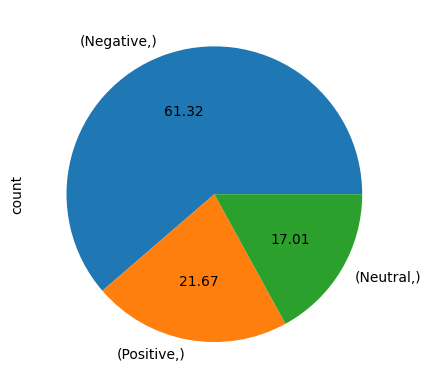

In [12]:
y.value_counts().plot.pie(autopct='%0.2f')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
X_train.count()

ProcessText    781
dtype: int64

In [15]:
X_test.count()

ProcessText    336
dtype: int64

In [16]:
y_train.value_counts()

ActualLabel
Negative       467
Positive       173
Neutral        141
Name: count, dtype: int64

In [17]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = {'Negative': 150, 'Positive': 150, 'Neutral': 141}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res, y_res = rus.fit_resample(X_train, y_train)

In [18]:
# Fit the TfidfVectorizer to determine the number of features
tfidf_vectorizer = TfidfVectorizer()
X_train = X_train.squeeze()
X_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Determine the number of features
num_features = X_tfidf.shape[1]

# Set 'k' to the minimum of 500 or the number of features
k_best = min(500, num_features)

#select_k_best = SelectKBest(chi2, k=k_best)

In [19]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('chi2', SelectKBest(chi2, k=k_best)),  # k is the number of features to select
    ('nb', MultinomialNB())
])

In [20]:
X_train = X_res.squeeze()
y_train = y_res.squeeze()

In [21]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('chi2',
                 SelectKBest(k=500,
                             score_func=<function chi2 at 0x000002BE490D07C0>)),
                ('nb', MultinomialNB())])

In [22]:
X_test = X_test.squeeze()

In [23]:
y_pred = pipeline.predict(X_test)

In [24]:
y_pred

array(['Negative', 'Negative', 'Positive', 'Negative', 'Negative',
       'Neutral', 'Negative', 'Neutral', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Neutral', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Positive', 'Negative', 'Negative',
       'Positive', 'Negative', 'Negative', 'Positive', 'Neutral',
       'Positive', 'Negative', 'Positive', 'Neutral', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Positive',
       'Positive', 'Negative', 'Negative', 'Neutral', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Neutral', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Neutral', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Neutral',
       'Negative', 'Negative', 'Neutral', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Neutral',
      

In [25]:
from collections import Counter

# Assuming y_pred is your array of predictions
label_counts = Counter(y_pred)

# To display the count of each unique label
for label, count in label_counts.items():
    print(f'Label: {label}, Count: {count}')

Label: Negative, Count: 241
Label: Positive, Count: 44
Label: Neutral, Count: 51


In [26]:
# Access the TF-IDF Vectorizer step
tfidf_vectorizer = pipeline.named_steps['tfidf']
# Get the feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Access the SelectKBest step
chi2_selector = pipeline.named_steps['chi2']
# Get the scores and p-values
chi2_scores = chi2_selector.scores_
chi2_pvalues = chi2_selector.pvalues_

# Get the indices of the selected features
selected_indices = chi2_selector.get_support(indices=True)
# Get the names of the selected features
selected_features = feature_names[selected_indices]

In [27]:
feature_scores = pd.DataFrame({
    'Feature': selected_features,
    'Score': chi2_scores[selected_indices],
    'P-value': chi2_pvalues[selected_indices]
}).sort_values(by='Score', ascending=False)

In [28]:
tfidf_matrix = tfidf_vectorizer.transform(X_train)
average_tfidf_scores = tfidf_matrix.mean(axis=0).A1  # A1 flattens the array
tfidf_feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'Average TF-IDF Score': average_tfidf_scores
}).sort_values(by='Average TF-IDF Score', ascending=False)

In [29]:
print(tfidf_feature_scores)

         Feature  Average TF-IDF Score
56            ai              0.056597
999          job              0.038235
1235         not              0.037799
1533     replace              0.026744
1326      people              0.024071
...          ...                   ...
1782  supposedly              0.000152
1354       place              0.000152
303     chipotle              0.000152
1987         wet              0.000152
1671        size              0.000152

[2041 rows x 2 columns]


In [30]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

    Negative       0.70      0.77      0.73       218
     Neutral       0.10      0.10      0.10        49
    Positive       0.32      0.20      0.25        69

    accuracy                           0.56       336
   macro avg       0.37      0.36      0.36       336
weighted avg       0.53      0.56      0.54       336



In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1117, 1)
y shape: (1117, 1)


In [33]:
X = X.squeeze()
y = y.squeeze()

In [34]:
scores = cross_val_score(pipeline, X, y, cv=10)

In [35]:
print("Cross-validation scores for each fold:")
print(scores)

print("Average 10 fold cross-validation score:")
print(scores.mean())

Cross-validation scores for each fold:
[0.61607143 0.61607143 0.61607143 0.625      0.625      0.60714286
 0.60714286 0.61261261 0.6036036  0.61261261]
Average 10 fold cross-validation score:
0.6141328828828828
